<a href="https://colab.research.google.com/github/ridoya09/Proyek-Analisis-Data/blob/main/Engine_Apriori_LPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Representasi File analysis_engine.py

Kode di bawah ini menunjukkan bagaimana fungsi-fungsi yang sudah kita buat akan disusun dalam satu file Python (`analysis_engine.py`) di backend aplikasi web. Web developer kemudian akan mengimpor dan memanggil fungsi-fungsi ini dari framework web (misalnya, Flask atau Django).

In [2]:
import pandas as pd
import numpy as np
import warnings
import os
from sklearn.cluster import KMeans
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori

# Suppress DeprecationWarning from jupyter_client - might still be useful depending on server environment
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn") # Suppress KMeans warnings


def process_data_with_kmeans(file_path_association, k_categorization=5):
    """
    Loads data from an Excel file, performs K-Means categorization on specified
    rate columns after outlier filtering, and returns the processed DataFrame
    with new category columns and cluster labels, along with cluster information.

    Args:
        file_path_association (str): The path to the input Excel file.
        k_categorization (int, optional): The number of clusters for K-Means.
                                           Defaults to 5.

    Returns:
        tuple: A tuple containing:
            - df_association (pd.DataFrame): The DataFrame with added LPO category
                                           and ClusterLabel columns. Returns an empty
                                           DataFrame if file loading or processing fails.
            - cluster_info (dict): A dictionary containing boundary and centroid
                                   information for each categorized column. Returns
                                   an empty dictionary if processing fails.
    """
    df_association = pd.DataFrame()
    cluster_info = {}

    # --- Step 1: Load the Excel file ---
    try:
        # Check if the file exists
        if not os.path.exists(file_path_association):
            print(f"Error: File not found at '{file_path_association}'")
            return df_association, cluster_info
        elif not file_path_association.lower().endswith('.xlsx'):
            print(f"Error: File is not an Excel file (.xlsx). Please provide a valid Excel file path.")
            return df_association, cluster_info
        else:
            df_association = pd.read_excel(file_path_association)
            print(f"Successfully loaded data from '{file_path_association}'")

    except Exception as e:
        print(f"An error occurred while loading the file: {e}")
        return df_association, cluster_info

    # --- Check if DataFrame was loaded successfully before proceeding ---
    if df_association.empty:
        return df_association, cluster_info # Return empty df and info if loading failed


    # --- Step 2: Categorization based on K-Means boundaries and Assign Cluster Labels ---
    target_columns_for_categorization = ['GAS RATE', 'OIL RATE', 'CONDENSATE RATE']

    # print("\n--- Calculating cluster boundaries for categorization ---") # Commented out
    for column in target_columns_for_categorization:
        # Initialize outlier bounds to None at the start of each loop iteration
        lower_bound_outlier = None
        upper_bound_outlier = None

        # print(f"Processing column for categorization: {column}") # Commented out
        if column not in df_association.columns:
             # print(f"Column '{column}' not found in df_association. Skipping boundary calculation.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_bound_outlier}
             # Add a placeholder cluster label column with NaN or -1 if column is missing
             df_association[f'{column}_ClusterLabel'] = np.nan
             continue

        # Handle potential NaN values in the column before calculating quartiles
        if df_association[column].dropna().empty:
             # print(f"Column '{column}' is empty or contains only NaN values. Skipping boundary calculation.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_bound_outlier}
             # Add a placeholder cluster label column with NaN
             df_association[f'{column}_ClusterLabel'] = np.nan
             continue

        # --- Outlier Filtering Bounds Calculation ---
        Q1_outlier = df_association[column].quantile(0.25)
        Q3_outlier = df_association[column].quantile(0.75)
        IQR_outlier = Q3_outlier - Q1_outlier
        lower_bound_outlier = Q1_outlier - 1.5 * IQR_outlier
        upper_bound_outlier = Q3_outlier + 1.5 * IQR_outlier
        # --- End Outlier Filtering Bounds Calculation ---


        # Use only non-outlier data for clustering
        df_non_outlier_col = df_association.loc[(df_association[column] >= lower_bound_outlier) & (df_association[column] <= upper_bound_outlier)].copy()
        df_non_outlier_col = df_non_outlier_col.dropna(subset=[column])


        # Check if there's enough data for clustering for this column
        if df_non_outlier_col.empty or k_categorization < 2 or len(np.unique(df_non_outlier_col[column].dropna())) < k_categorization:
             # print(f"Skipping clustering/boundary calculation for '{column}' due to insufficient non-outlier data ({len(df_non_outlier_col)}) or unique values ({len(np.unique(df_non_outlier_col[column].dropna()))}) for k={k_categorization}.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_bound_outlier}
             # Add a placeholder cluster label column with NaN for all rows in the original df
             df_association[f'{column}_ClusterLabel'] = np.nan
             continue


        # --- Apply KMeans Clustering ---
        X = df_non_outlier_col[[column]].values
        # Add check for number of samples vs clusters
        if len(X) < k_categorization:
             # print(f"Not enough data points ({len(X)}) for clustering '{column}' with k={k_categorization}. Skipping.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_outlier_bound}
             # Add a placeholder cluster label column with NaN for all rows in the original df
             df_association[f'{column}_ClusterLabel'] = np.nan
             continue


        kmeans = KMeans(n_clusters=k_categorization, random_state=42, n_init=10)
        # Ensure X is not empty before fitting KMeans
        if not df_non_outlier_col.empty:
             # Fit KMeans only to the non-outlier data
             kmeans.fit(X)
             centroids = kmeans.cluster_centers_
             # Sort centroids to ensure consistent boundary order
             sorted_centroid_indices = np.argsort(centroids.flatten())
             sorted_centroids = centroids[sorted_centroid_indices]

             cluster_boundaries = [(sorted_centroids[i][0] + sorted_centroids[i+1][0]) / 2 for i in range(len(sorted_centroids)-1)]

             cluster_info[column] = {
                 'boundaries': cluster_boundaries,
                 'min': df_non_outlier_col[column].min(),
                 'max': df_non_outlier_col[column].max(),
                 'lower_outlier_bound': lower_bound_outlier,
                 'upper_outlier_bound': upper_bound_outlier,
                 'sorted_centroids': sorted_centroids.flatten().tolist() # Store sorted centroids as well
             }

             # --- Assign Cluster Labels back to the original DataFrame ---
             # Predict cluster labels for the non-outlier data used for fitting
             labels_non_outlier = kmeans.predict(X)

             # Create a mapping from original cluster label to sorted centroid index (0 to k-1)
             # This ensures the labels are assigned in increasing order based on centroid values
             label_mapping = {original_label: sorted_label for sorted_label, original_label in enumerate(sorted_centroid_indices)}

             # Map the predicted labels to the sorted labels
             sorted_labels_non_outlier = np.vectorize(label_mapping.get)(labels_non_outlier)


             # Assign the sorted cluster labels back to the original df_association DataFrame
             # Initialize the new column with NaN
             df_association[f'{column}_ClusterLabel'] = np.nan
             # Use the index of the non-outlier DataFrame to assign labels correctly
             df_association.loc[df_non_outlier_col.index, f'{column}_ClusterLabel'] = sorted_labels_non_outlier

             # For outlier values (those outside the lower/upper bounds), assign a specific label if desired, e.g., -1 or np.nan
             # Current code leaves them as NaN, which is handled by dropna in plotting
             # If we want to assign a specific "Outlier" label, we could do:
             # df_association.loc[(df_association[column] < lower_outlier) | (df_association[column] > upper_outlier), f'{column}_ClusterLabel'] = -1 # Or a specific category string

        else:
             # print(f"DataFrame for '{column}' is empty after outlier filtering. Skipping clustering.") # Commented out
             cluster_info[column] = {'boundaries': [], 'min': None, 'max': None, 'lower_outlier_bound': lower_bound_outlier, 'upper_outlier_bound': upper_outlier_bound}
             # Add a placeholder cluster label column with NaN for all rows in the original df
             df_association[f'{column}_ClusterLabel'] = np.nan


    # print("Categorization complete and Cluster Labels Assigned.") # Commented out

    def categorize_rate_final_logic(rate, column_name, cluster_info_dict, k_val):
        # This function assigns the string category names (LPO GAS_low etc.)
        if pd.isna(rate):
            base_col_name = column_name.replace(' RATE', '')
            return f'LPO {base_col_name}_Unknown' # Handle NaN values (still use Unknown for NaN)

        info = cluster_info_dict.get(column_name)

        # --- Modified Logic: Assign category based on boundaries for *any* non-NaN value if boundaries exist ---
        # If clustering was skipped or no boundaries were calculated, use a 'Skipped' label
        if info is None or not info['boundaries']:
             base_col_name = column_name.replace(' RATE', '')
             return f'LPO {base_col_name}_CategorizationSkipped' # Use 'CategorizationSkipped' instead of Unknown

        boundaries = info['boundaries']
        if k_val == 5: category_names_logic = ["very low", "low", "moderate", "high", "very high"]
        elif k_val == 4: category_names_logic = ["low", "moderate", "high", "very high"]
        elif k_val == 3: category_names_logic = ["low", "moderate", "high"]
        else: category_names_logic = [f"Category {i+1}" for i in range(k_val)]

        # Assign category based on boundaries for *any* non-NaN value
        base_col_name = column_name.replace(' RATE', '')

        # Check if rate is below the first boundary
        if rate < boundaries[0]:
            return f'LPO {base_col_name}_{category_names_logic[0]}'
        # Check if rate is between boundaries
        for i in range(len(boundaries) - 1):
            if boundaries[i] <= rate < boundaries[i+1]:
                return f'LPO {base_col_name}_{category_names_logic[i+1]}'
        # If rate is >= the last boundary, it falls into the last category
        return f'LPO {base_col_name}_{category_names_logic[-1]}'
        # --- End Modified Logic ---


    # Apply the categorization function to the target columns
    # Ensure target columns exist before applying categorization
    # The categorization now uses the modified logic which applies to all non-NaN values
    if 'GAS RATE' in df_association.columns:
        df_association['LPO GAS KATEGORI'] = df_association['GAS RATE'].apply(lambda x: categorize_rate_final_logic(x, 'GAS RATE', cluster_info, k_categorization))
    else:
         df_association['LPO GAS KATEGORI'] = 'LPO GAS_ColumnMissing' # Format placeholder with LPO prefix

    if 'OIL RATE' in df_association.columns:
        df_association['LPO OIL KATEGORI'] = df_association['OIL RATE'].apply(lambda x: categorize_rate_final_logic(x, 'OIL RATE', cluster_info, k_categorization))
    else:
         df_association['LPO OIL KATEGORI'] = 'LPO OIL_ColumnMissing' # Format placeholder with LPO prefix

    if 'CONDENSATE RATE' in df_association.columns:
        df_association['LPO COND KATEGORI'] = df_association['CONDENSATE RATE'].apply(lambda x: categorize_rate_final_logic(x, 'CONDENSATE RATE', cluster_info, k_categorization))
    else:
         df_association['LPO COND KATEGORI'] = 'LPO COND_ColumnMissing' # Format placeholder with LPO prefix


    # print("Categorization complete and Cluster Labels Assigned.") # Commented out

    # Return the processed DataFrame and cluster info
    return df_association, cluster_info


def find_association_rules(df, selected_columns, min_support=0.01, min_confidence=0.5, lift_threshold=1):
    """
    Prepares data for Apriori, applies the algorithm, and generates association rules.

    Args:
        df (pd.DataFrame): The input DataFrame (e.g., df_association).
        selected_columns (list): A list of column names to include in the analysis.
        min_support (float, optional): The minimum support threshold for Apriori.
                                        Defaults to 0.01.
        min_confidence (float, optional): The minimum confidence threshold for rules.
                                          Defaults to 0.5.
        lift_threshold (float, optional): The minimum lift threshold for rules.
                                          Defaults to 1.

    Returns:
        pd.DataFrame: The DataFrame of association rules. Returns an empty DataFrame
                      if the process fails or no rules are found.
    """
    rules = pd.DataFrame() # Initialize rules DataFrame


    if not selected_columns:
        print("No columns selected. Cannot proceed with association rule mining.")
        return rules # Return empty rules if no columns selected

    # --- Prepare Data for Apriori ---
    # Check if all selected columns exist in the DataFrame
    missing_columns = [col for col in selected_columns if col not in df.columns]
    if missing_columns:
        print(f"Error: The following selected columns were not found in the DataFrame: {missing_columns}")
        return rules # Return empty rules if columns are missing

    # Select the chosen columns.
    df_apriori_prep = df[selected_columns].copy()

    # Handle any missing values in the selected columns.
    initial_rows = df_apriori_prep.shape[0]
    df_apriori_prep = df_apriori_prep.dropna(subset=selected_columns) # Dropna based on selected columns
    rows_after_dropna = df_apriori_prep.shape[0]
    if initial_rows > rows_after_dropna:
        print(f"Dropped {initial_rows - rows_after_dropna} rows with missing values in selected columns.")


    # Filter out rows where LPO category columns are 'Unknown'
    # Apply this filter only if the category columns were selected
    category_cols_to_filter = ['LPO GAS KATEGORI', 'LPO OIL KATEGORI', 'LPO COND KATEGORI']
    selected_category_cols_to_filter = [col for col in selected_columns if col in category_cols_to_filter and col in df_apriori_prep.columns]

    filter_mask = pd.Series(False, index=df_apriori_prep.index) # Initialize with False

    for cat_col in selected_category_cols_to_filter:
         if cat_col in df_apriori_prep.columns:
              if pd.api.types.is_object_dtype(df_apriori_prep[cat_col]) or pd.api.types.is_string_dtype(df_apriori_prep[cat_col]):
                   # Filter out 'Unknown' categories from selected LPO columns
                   # Keep 'CategorizationSkipped' as requested
                   filter_mask = filter_mask | df_apriori_prep[cat_col].str.contains('_Unknown', na=False)


    rows_before_category_filter = df_apriori_prep.shape[0]
    df_apriori_prep = df_apriori_prep[~filter_mask].copy()
    rows_after_category_filter = df_apriori_prep.shape[0]

    if rows_before_category_filter > rows_after_category_filter:
         print(f"Dropped {rows_before_category_filter - rows_after_category_filter} rows with 'Unknown' categories in selected LPO columns.")


    if df_apriori_prep.empty:
         print("No data remaining after filtering out 'Unknown' categories. Cannot proceed with encoding.")
         return rules # Return empty rules if data is empty after filtering


    # Transform the filtered DataFrame into a list of lists (transactions).
    # Include all selected columns for encoding (both original and LPO categories)
    columns_for_encoding = [col for col in df_apriori_prep.columns if (pd.api.types.is_object_dtype(df_apriori_prep[col]) or pd.api.types.is_string_dtype(df_apriori_prep[col])) and col in df_apriori_prep.columns]

    # Add a check to ensure there are columns to encode
    if not columns_for_encoding:
        print("No valid columns for encoding found after filtering. Cannot perform Transaction Encoding.")
        return rules # Return empty rules if no columns to encode

    transactions = []
    # Use the values directly from df_apriori_prep
    for index, row in df_apriori_prep[columns_for_encoding].iterrows():
        transaction = [str(row[col]) for col in columns_for_encoding if pd.notna(row[col])]
        if transaction: # Only add non-empty transactions
             transactions.append(transaction)

    if not transactions:
         print("No valid transactions found after preparing for encoding. Cannot perform Transaction Encoding.")
         return rules # Return empty rules if no transactions

    # Instantiate TransactionEncoder.
    # Fit and transform.
    print("\nPreparing data using TransactionEncoder...")
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)

    # Convert to pandas DataFrame.
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    # print("Transaction Encoding complete. Displaying head of encoded DataFrame:") # Commented out
    # display(df_encoded.head()) # Commented out
    print(f"Shape of encoded DataFrame: {df_encoded.shape}")


    # --- Apply Apriori Algorithm and Generate Rules ---
    # This block should only run if df_encoded was successfully created AND has valid boolean columns
    if df_encoded.shape[0] < 1 or df_encoded.shape[1] < 2: # Check for at least 2 columns/items for association
         print(f"\nDataFrame encoded is empty or has fewer than 2 columns ({df_encoded.shape[1]}) after preparation. Cannot apply Apriori.")
         return rules # Return empty rules if not enough data/columns
    elif not all(df_encoded.dtypes == bool):
        print("\nEncoded DataFrame contains non-boolean columns. Please check data preparation steps. Cannot apply Apriori.")
        print("Column dtypes:", df_encoded.dtypes)
        return rules # Return empty rules if dtypes are wrong
    else:
        print("\n--- Applying Apriori Algorithm and Generating Rules ---")
        # Apply the Apriori algorithm

        frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

        if not frequent_itemsets.empty:
            print("Frequent itemsets found. Generating association rules...")
            # Generate association rules
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

            # Filter rules by lift >= lift_threshold
            rules = rules[rules['lift'] >= lift_threshold]

            if rules.empty:
                 print(f"No association rules found with min_confidence={min_confidence} and lift>={lift_threshold}.")
            else:
                 print("Association rules generated.")


        else:
            print(f"Could not generate association rules because no frequent itemsets were found with the given minimum support ({min_support}).")
            # rules is already initialized as empty, no need to redefine

    # Return the generated rules DataFrame
    return rules

def get_top_association_rules(rules_df, top_n=10):
    """
    Sorts association rules based on consequent/antecedent category order,
    confidence, and lift, and returns the top N rules.

    Args:
        rules_df (pd.DataFrame): The input DataFrame of association rules.
        top_n (int, optional): The number of top rules to return. Defaults to 10.

    Returns:
        pd.DataFrame: A DataFrame containing the top N sorted association rules.
                      Returns an empty DataFrame if the input is empty or invalid.
    """
    if rules_df.empty:
        print("Input DataFrame of rules is empty. Cannot get top rules.")
        return pd.DataFrame() # Return empty DataFrame if input is empty

    # Ensure necessary columns exist
    required_cols = ['antecedents', 'consequents', 'confidence', 'lift']
    if not all(col in rules_df.columns for col in required_cols):
        print(f"Error: Input rules DataFrame is missing required columns: {list(set(required_cols) - set(rules_df.columns))}")
        return pd.DataFrame()


    # --- Custom Sorting Logic: Based on Category Order ---
    # Define the desired order of categories (from highest to lowest)
    category_order = ["very high", "high", "moderate", "low", "very low", "unknown", "categorizationskipped", "columnmissing"] # Include other potential categories and their order


    # Function to extract the category suffix from an item string
    def extract_category_suffix(item):
        item_lower = str(item).lower()
        # Check for LPO format first
        if item_lower.startswith('lpo '):
             parts = item_lower.split('_')
             if len(parts) > 1:
                  # The last part is the category name
                  return parts[-1]
        # Fallback or other non-LPO items - return a default or the whole item string
        return item_lower # Use the whole item if not in LPO format


    # Function to get a numerical score for sorting based on category order
    def get_category_sort_score(items, order):
        scores = []
        for item in items:
            category = extract_category_suffix(item)
            try:
                # Assign a score based on the inverse of the index (higher index = lower score)
                score = len(order) - order.index(category)
                scores.append(score)
            except ValueError:
                # Category not in the defined order, assign a low score
                scores.append(0) # Assign 0 for unknown categories

            # If no categorized items are found, return a score based on presence of *any* item
            if not scores:
                return 0 if not items else 1 # Assign a basic score if items exist but no known categories

            # Combine scores for multiple items in an itemset (e.g., sum or max)
            # Using max score to prioritize itemsets with higher categories
            return max(scores)


    # Apply the custom sorting score to antecedents and consequents
    # Work on a copy to avoid modifying the original rules_df outside the function if it was passed by reference
    rules_df_sorted = rules_df.copy()
    rules_df_sorted['antecedent_category_score'] = rules_df_sorted['antecedents'].apply(lambda x: get_category_sort_score(x, category_order))
    rules_df_sorted['consequent_category_score'] = rules_df_sorted['consequents'].apply(lambda x: get_category_sort_score(x, category_order))

    # Sort first by consequent category score (descending), then antecedent category score (descending),
    # then by confidence (descending), then lift (descending)
    sorted_rules_summary = rules_df_sorted.sort_values(
        by=['consequent_category_score', 'antecedent_category_score', 'confidence', 'lift'],
        ascending=[False, False, False, False]
    ).drop(['antecedent_category_score', 'consequent_category_score'], axis=1).copy() # Drop the temporary score columns and use .copy()


    # --- End Custom Sorting Logic ---

    # Return only the top N rules
    return sorted_rules_summary.head(top_n)


def filter_association_rules_by_keyword(rules_df, keyword):
    """
    Filters association rules based on a keyword present in either the
    antecedents or consequents.

    Args:
        rules_df (pd.DataFrame): The input DataFrame of association rules.
        keyword (str): The keyword to filter by. Filtering is case-insensitive.

    Returns:
        pd.DataFrame: A DataFrame containing the filtered association rules.
                      Returns an empty DataFrame if input is empty, keyword is empty,
                      or no matching rules are found.
    """
    if rules_df.empty:
        # print("Input DataFrame of rules is empty. Cannot filter.") # Handled by caller
        return pd.DataFrame()

    if not keyword:
        # print("No keyword provided. Returning all rules.") # Handled by caller
        return rules_df.copy() # Return a copy if no keyword

    # Convert keyword to lowercase for case-insensitive filtering
    keyword_lower = keyword.lower()

    # Filter rules where the keyword is present in either antecedents or consequents
    # Need to convert frozensets to strings for searching
    filtered_rules = rules_df[
        rules_df['antecedents'].astype(str).str.lower().str.contains(keyword_lower, na=False) |
        rules_df['consequents'].astype(str).str.lower().str.contains(keyword_lower, na=False)
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    return filtered_rules

# --- Example Usage (for testing within notebook) ---
# Assuming df_association and rules DataFrames are available from previous steps

# # Example 1: Process data and find rules
# file_path = "/content/drive/MyDrive/Proyekan Mas Ivan/SF Jan-Aug 2025.xlsx"
# k_value = 5
# selected_columns_for_apriori = ['EVENTNAME', 'EVENTDAYWELLNAME', 'LPO GAS KATEGORI', 'LPO OIL KATEGORI', 'LPO COND KATEGORI']
# min_support_value = 0.01
# min_confidence_value = 0.5
# lift_threshold_value = 1

# df_association_processed, cluster_info_result = process_data_with_kmeans(file_path, k_value)

# if not df_association_processed.empty:
#      rules_result = find_association_rules(df_association_processed, selected_columns_for_apriori, min_support_value, min_confidence_value, lift_threshold_value)

#      # Example 2: Get top rules
#      if not rules_result.empty:
#          top_rules_display = 10
#          print(f"\n--- Top {top_rules_display} Association Rules ---")
#          pd.options.display.float_format = '{:,.4f}'.format
#          display(get_top_association_rules(rules_result, top_rules_display))

#          # Example 3: Filter rules by keyword
#          filter_keyword = input("Enter keyword to filter rules: ")
#          print(f"\n--- Filtered Association Rules for keyword: '{filter_keyword}' ---")
#          pd.options.display.float_format = '{:,.4f}'.format
#          display(filter_association_rules_by_keyword(rules_result, filter_keyword))
#      else:
#          print("\nNo rules generated to get top rules or filter.")
# else:
#      print("\nData processing failed. Cannot find rules, get top rules, or filter rules.")

In [3]:
# --- Cell 1: Call to process_data_with_kmeans Function ---

# Ensure the function process_data_with_kmeans is defined (e.g., by running cell 22dfe91b)
if 'process_data_with_kmeans' not in globals():
    print("Error: Function 'process_data_with_kmeans' not found. Please run the cell containing the function definitions first.")
    df_association = pd.DataFrame() # Initialize to prevent errors
    cluster_info = {} # Initialize to prevent errors
else:
    # Define the file path and k value here before calling the function
    file_path = "/content/drive/MyDrive/Proyekan Mas Ivan/SF Jan-Aug 2025.xlsx"
    # Assuming k is available from cell OjdosFsFr7kn. If not, set a default.
    if 'k' not in globals():
        # print("Variable 'k' not found, using default k=5 for categorization.") # Commented out
        k_value = 3
    else:
        k_value = globals()['k']

    # Call the function and assign the returned values to variables
    df_association, cluster_info = process_data_with_kmeans(file_path, k_value)

    # Optional: Display head of the processed DataFrame after the function call
    if not df_association.empty:
        print("\nDataFrame 'df_association' after processing and categorization:")
        # Display relevant columns including the new LPO categories and cluster labels
        display(df_association[['GAS RATE', 'OIL RATE', 'CONDENSATE RATE',
                                'LPO GAS KATEGORI', 'LPO OIL KATEGORI', 'LPO COND KATEGORI',
                                'GAS RATE_ClusterLabel', 'OIL RATE_ClusterLabel', 'CONDENSATE RATE_ClusterLabel']].head())

    # Optional: Generate and display the formatted cluster ranges string after the function call
    if cluster_info:
        formatted_output_lines = ["Rentang Nilai Berdasarkan Batas Klaster:"]

        # Ensure k_value is available
        # k_value is defined above, no need to check globals/locals again

        # Define category names based on k_value
        if k_value == 5:
            category_names_display = ["very low", "low", "moderate", "high", "very high"]
        elif k_value == 4:
             category_names_display = ["low", "moderate", "high", "very high"]
        elif k_value == 3:
             category_names_display = ["low", "moderate", "high"]
        else:
             category_names_display = [f"Category {i+1}" for i in range(k_value)] # Generic names


        for col_name_long, info in cluster_info.items(): # Iterate through cluster_info
            col_name_short = col_name_long.replace(' RATE', '').replace('LPO ', '').replace(' KATEGORI', '')
            formatted_output_lines.append(f"\n--- {col_name_long} ---") # Display full column name

            boundaries = info.get('boundaries', [])
            min_val = info.get('min')
            max_val = info.get('max')
            lower_outlier_display = info.get('lower_outlier_bound') # Use a different variable name for clarity
            upper_outlier_display = info.get('upper_outlier_bound') # Use a different variable name for clarity


            if not boundaries:
                 formatted_output_lines.append("  Kategorisasi dilewati karena data tidak mencukupi atau k tidak sesuai.")
                 if lower_outlier_display is not None and upper_outlier_display is not None:
                      formatted_output_lines.append(f"  Rentang data non-outlier: >= {lower_outlier_display:.4f} dan <= {upper_outlier_display:.4f}")
                 elif min_val is not None and max_val is not None:
                      formatted_output_lines.append(f"  Rentang data: >= {min_val:.4f} dan <= {max_val:.4f}")

            else:
                # Ensure the number of category names matches the number of expected ranges (boundaries + 1)
                if len(category_names_display) != len(boundaries) + 1:
                     # Handle mismatch - maybe log a warning or add a specific row
                     formatted_output_lines.append(f"  Warning: Number of category names ({len(category_names_display)}) does not match expected ranges ({len(boundaries) + 1}). Raw boundaries: {boundaries}")
                     # formatted_output_lines.append(f"  Boundaries: {boundaries}") # Can include raw boundaries as well
                     # Add other info if needed for debugging
                     if min_val is not None: formatted_output_lines.append(f"  Min (non-outlier): {min_val:.4f}")
                     if max_val is not None: formatted_output_lines.append(f"  Max (non-outlier): {max_val:.4f}")
                     if lower_outlier_display is not None: formatted_output_lines.append(f"  Lower Outlier Bound: {lower_outlier_display:.4f})")
                     if upper_outlier_display is not None: formatted_output_lines.append(f"  Upper Outlier Bound: {upper_outlier_display:.4f})")


                else:
                    # Format the ranges using the category names
                    formatted_output_lines.append(f"  {category_names_display[0]}: < {boundaries[0]:.4f}")
                    for i in range(len(boundaries) - 1):
                        formatted_output_lines.append(f"  {category_names_display[i+1]}: {boundaries[i]:.4f} <= value < {boundaries[i+1]:.4f}")
                    # Fix: Use category_names_display here
                    formatted_output_lines.append(f"  {category_names_display[-1]}: >= {boundaries[-1]:.4f}")

        kmeans_ranges_output = "\n".join(formatted_output_lines)
        print("\nK-Means Cluster Ranges:")
        print(kmeans_ranges_output)

# Note: df_association and cluster_info are now available in the global scope after the function call

Successfully loaded data from '/content/drive/MyDrive/Proyekan Mas Ivan/SF Jan-Aug 2025.xlsx'

DataFrame 'df_association' after processing and categorization:


,GAS RATE,OIL RATE,CONDENSATE RATE,LPO GAS KATEGORI,LPO OIL KATEGORI,LPO COND KATEGORI,GAS RATE_ClusterLabel,OIL RATE_ClusterLabel,CONDENSATE RATE_ClusterLabel
0,0.007500,0.000000,0.0,LPO GAS_moderate,LPO OIL_low,LPO CONDENSATE_CategorizationSkipped,1.0,0.0,NaN
1,0.000000,0.374709,0.0,LPO GAS_low,LPO OIL_moderate,LPO CONDENSATE_CategorizationSkipped,0.0,1.0,NaN
2,0.020833,9.291667,0.0,LPO GAS_high,LPO OIL_high,LPO CONDENSATE_CategorizationSkipped,2.0,NaN,NaN
3,0.003472,0.000000,0.0,LPO GAS_low,LPO OIL_low,LPO CONDENSATE_CategorizationSkipped,0.0,0.0,NaN
4,0.008333,10.416667,0.0,LPO GAS_moderate,LPO OIL_high,LPO CONDENSATE_CategorizationSkipped,1.0,NaN,NaN



K-Means Cluster Ranges:
Rentang Nilai Berdasarkan Batas Klaster:

--- GAS RATE ---
  low: < 0.0059
  moderate: 0.0059 <= value < 0.0196
  high: >= 0.0196

--- OIL RATE ---
  low: < 0.1720
  moderate: 0.1720 <= value < 0.5613
  high: >= 0.5613

--- CONDENSATE RATE ---
  Kategorisasi dilewati karena data tidak mencukupi atau k tidak sesuai.
  Rentang data non-outlier: >= 0.0000 dan <= 0.0000


Generating Histograms colored by K-Means Cluster Label (where possible):
  Histogram for 'GAS RATE' colored by Cluster Indices: [np.int64(0), np.int64(1), np.int64(2)]
  Histogram for 'OIL RATE' colored by Cluster Indices: [np.int64(0), np.int64(1), np.int64(2)]
K-Means clustering did not yield enough valid clusters for 'CONDENSATE RATE'. Plotting basic histogram.


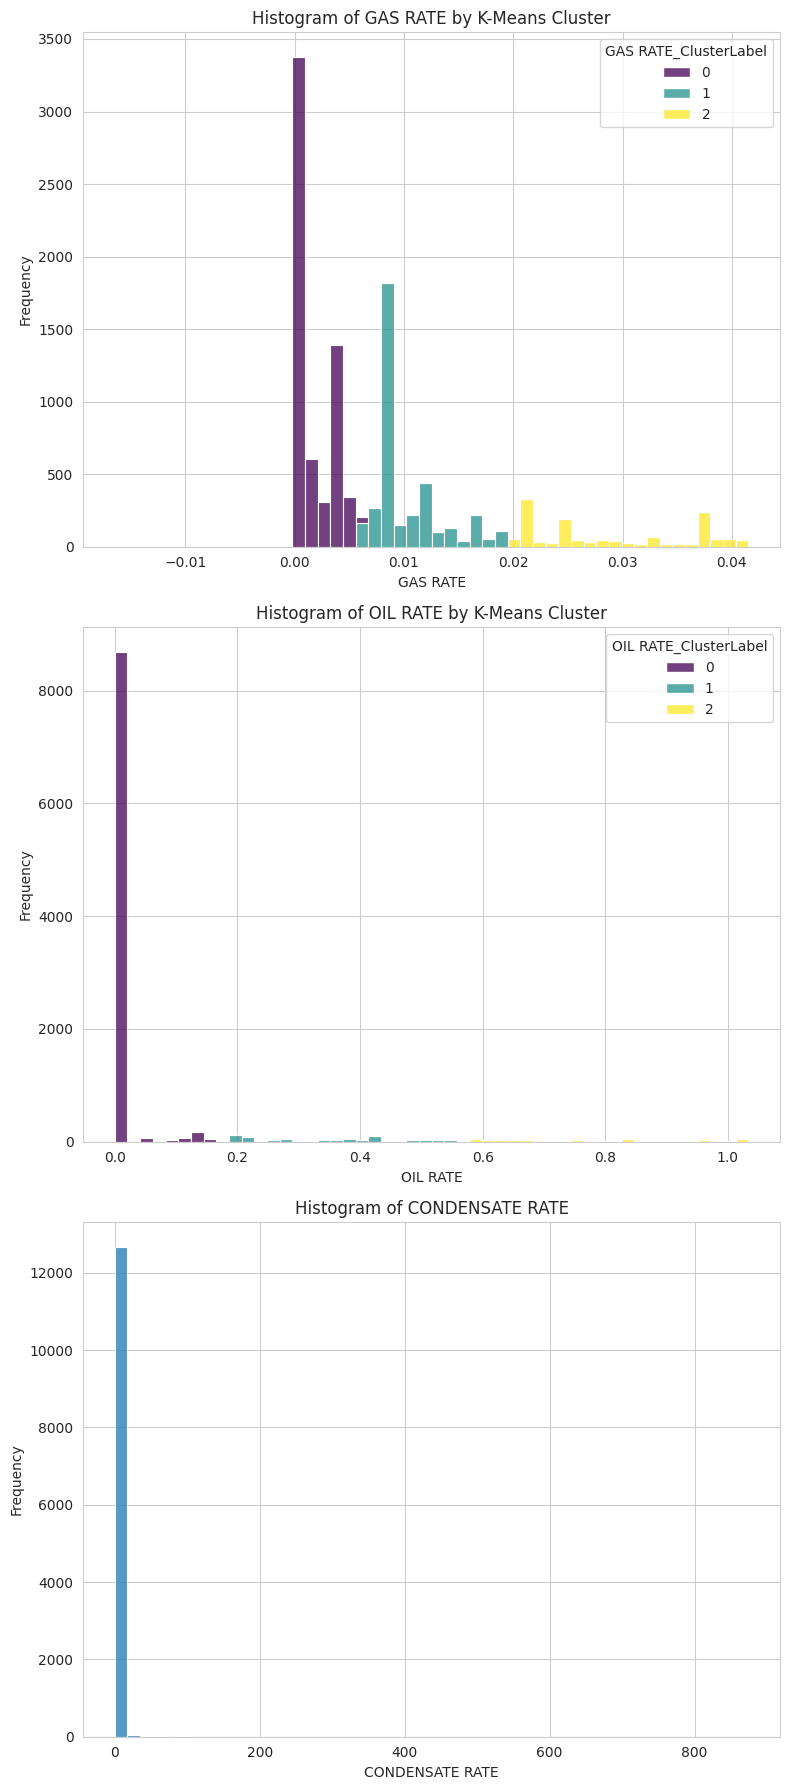

In [10]:
# --- Verification Cell: Histogram of K-Means Results (Colored by Cluster or Basic, Uniform Appearance) ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy for plotting logic

# Ensure df_association and cluster_info exist from the previous cell
if ('df_association' in locals() or 'df_association' in globals()) and \
   ('cluster_info' in locals() or 'cluster_info' in globals()):

    df = globals().get('df_association')
    cluster_info = globals().get('cluster_info')
    target_columns = ['GAS RATE', 'OIL RATE', 'CONDENSATE RATE'] # Original columns used for categorization

    print("Generating Histograms colored by K-Means Cluster Label (where possible):")

    # Determine the number of plots needed (plot all target columns if they exist)
    columns_to_plot = [col for col in target_columns if col in df.columns]

    if not columns_to_plot:
        print("None of the target columns ('GAS RATE', 'OIL RATE', 'CONDENSATE RATE') found in df_association. Cannot generate histograms.")
    else:
        num_plots = len(columns_to_plot)
        # Adjust layout based on number of plots - Vertical layout
        fig, axes = plt.subplots(num_plots, 1, figsize=(8, 6 * num_plots)) # 8 wide, 6*num_plots tall


        # Ensure axes is an array even for a single subplot
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])

        # Set a consistent number of bins for all histograms
        consistent_bins = 50 # You can adjust this number


        # Apply a Seaborn style for better aesthetics
        sns.set_style("whitegrid") # Or "ticks", "darkgrid", "white"


        for i, column in enumerate(columns_to_plot):
            ax = axes[i] # Get the correct subplot axis
            label_col = f'{column}_ClusterLabel' # Get the name of the cluster label column

            # Check if cluster labels are available and meaningful for this column
            plot_colored_histogram = False
            df_plot_colored = pd.DataFrame() # Initialize empty DataFrame for colored plot
            unique_labels = [] # Initialize unique labels list

            if label_col in df.columns:
                 # Filter out rows where the label is NaN for colored plotting
                 # Also drop NaNs from the data column itself
                 df_plot_colored = df.dropna(subset=[column, label_col]).copy()

                 if not df_plot_colored.empty:
                      # Convert labels to integer type for plotting
                      # Handle potential float conversion issues from NaN
                      df_plot_colored[label_col] = df_plot_colored[label_col].astype(int)
                      unique_labels = sorted(df_plot_colored[label_col].unique())
                      # Exclude -1 if it's used for outliers
                      unique_labels = [lbl for lbl in unique_labels if lbl >= 0] # Assuming labels are 0, 1, ..., k-1

                      # Check if there are enough unique, non-negative labels for hue plotting
                      if len(unique_labels) > 1:
                          plot_colored_histogram = True
                          hue_order = unique_labels # Use the valid unique labels for order


            if plot_colored_histogram:
                 # Print which cluster indices are being plotted in color
                 print(f"  Histogram for '{column}' colored by Cluster Indices: {unique_labels}")

                 # Plot histogram colored by cluster label with consistent bins
                 sns.histplot(data=df_plot_colored, x=column, hue=label_col, multiple="stack", kde=False, ax=ax, hue_order=hue_order, palette="viridis", bins=consistent_bins) # Use multiple="stack" for stacked bars, kde=False, added bins
                 ax.set_title(f'Histogram of {column} by K-Means Cluster')
                 ax.set_xlabel(column)
                 ax.set_ylabel('Frequency')

                 # --- Corrected Legend Generation ---
                 # Get handles and labels from the plot artists
                 handles, labels = ax.get_legend_handles_labels()
                 # Ensure handles were generated before trying to create legend
                 if handles:
                      # Ensure the number of labels matches the number of handles, use unique_labels as labels
                      if len(handles) == len(unique_labels):
                           ax.legend(handles=handles, labels=unique_labels, title="Cluster Index")
                      else:
                           # Fallback if number of handles doesn't match unique_labels (unexpected)
                           ax.legend(title="Cluster Index (Labels Mismatch)")
                           print(f"  Warning: Number of legend handles ({len(handles)}) does not match unique cluster labels ({len(unique_labels)}) for '{column}'. Legend might be incorrect.")

                 # --- End Corrected Legend Generation ---


            else:
                 # Fallback to plotting a simple histogram of the original data if colored plot is not possible
                 print(f"K-Means clustering did not yield enough valid clusters for '{column}'. Plotting basic histogram.")
                 # Use the original column data, dropping NaNs only for the plotting column, with consistent bins and no kde
                 sns.histplot(df[column].dropna(), kde=False, ax=ax, bins=consistent_bins) # Plot basic histogram with kde=False, added bins
                 ax.set_title(f'Histogram of {column}')
                 ax.set_xlabel(column)
                 ax.set_ylabel('Frequency')

                 # Removed the code that adds vertical boundary lines

            # Ensure y-axis starts at 0 for better comparison
            ax.set_ylim(bottom=0)


        plt.tight_layout()
        plt.show()

else:
    # Check which variable is missing for a more specific error message
    if 'df_association' not in locals() and 'df_association' not in globals():
         print("DataFrame 'df_association' not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully.")
    elif 'cluster_info' not in locals() and 'cluster_info' not in globals():
         print("Dictionary 'cluster_info' not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully.")
    else:
        print("Required variables ('df_association', 'cluster_info') not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully.")

In [11]:
# --- Verification Cell: Display df_association after Categorization ---

from IPython.display import display

# Check if df_association exists from the previous cell
if 'df_association' in locals() or 'df_association' in globals():
    print("Displaying head of df_association after K-Means Categorization:")
    display(df_association)
else:
    print("DataFrame 'df_association' not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully.")

Displaying head of df_association after K-Means Categorization:


,EVENTNAME,EVENTSTARTTIME,EVENTENDTIME,EVENTSTATUS,EVENTDAYREGIONNAME,EVENTDAYZONENAME,EVENTDAYASSETNAME,EVENTDAYBLOCKFIELDNAME,EVENTDAYASSETOPERATIONNAME,EVENTDAYWELLNAME,...,GAS RATE,OIL RATE,CONDENSATE RATE,SIBU/NonSIBU,GAS RATE_ClusterLabel,OIL RATE_ClusterLabel,CONDENSATE RATE_ClusterLabel,LPO GAS KATEGORI,LPO OIL KATEGORI,LPO COND KATEGORI
0,SFENP_EQIN,2025-01-01 00:00:00,2025-01-02,Close,Regional 3,Zona 8,Mahakam,PECIKO,SWP-K,PK-K25-oSH1-S1,...,0.0075,0.0000,0.0000,NonSIBU,1.0000,0.0000,NaN,LPO GAS_moderate,LPO OIL_low,LPO CONDENSATE_CategorizationSkipped
1,WRP_WSER,2025-01-01 21:05:00,2025-01-02,Close,Regional 3,Zona 8,Mahakam,HANDIL,CLUSTER HCB,H-CB-368-S1,...,0.0000,0.3747,0.0000,NonSIBU,0.0000,1.0000,NaN,LPO GAS_low,LPO OIL_moderate,LPO CONDENSATE_CategorizationSkipped
2,SFOP_OTHER,2025-01-01 00:00:00,2025-01-02,Close,Regional 3,Zona 8,Mahakam,BEKAPAI,PLATFORM BL,B-L-15-S1,...,0.0208,9.2917,0.0000,NonSIBU,2.0000,NaN,NaN,LPO GAS_high,LPO OIL_high,LPO CONDENSATE_CategorizationSkipped
3,WRNP_WDI,2025-01-01 00:00:00,2025-01-02,Close,Regional 3,Zona 8,Mahakam,PECIKO,SWP-E,PK-E21-bSH2-S1,...,0.0035,0.0000,0.0000,SIBU,0.0000,0.0000,NaN,LPO GAS_low,LPO OIL_low,LPO CONDENSATE_CategorizationSkipped
4,WENP_OWHE,2025-01-01 00:00:00,2025-01-02,Close,Regional 3,Zona 8,Mahakam,BEKAPAI,PLATFORM BG,B-G-10-S1,...,0.0083,10.4167,0.0000,SIBU,1.0000,NaN,NaN,LPO GAS_moderate,LPO OIL_high,LPO CONDENSATE_CategorizationSkipped
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12771,WOP_TEST,2025-08-31 00:00:00,2025-09-01,Close,Regional 3,Zona 8,Mahakam,HANDIL,CLUSTER HYA,H-YA-162-S1,...,0.0000,0.1667,0.0000,NonSIBU,0.0000,0.0000,NaN,LPO GAS_low,LPO OIL_low,LPO CONDENSATE_CategorizationSkipped
12772,WOP_OTHER,2025-08-31 00:00:00,2025-09-01,Close,Regional 3,Zona 8,Mahakam,HANDIL,CLUSTER HV,H-V-301-S1,...,0.0083,0.6500,0.0000,SIBU,1.0000,2.0000,NaN,LPO GAS_moderate,LPO OIL_high,LPO CONDENSATE_CategorizationSkipped
12773,WRP_RDAQ,2025-08-31 00:00:00,2025-09-01,Close,Regional 3,Zona 8,Mahakam,HANDIL,CLUSTER HV,H-V-414-S1,...,0.0000,17.5417,0.0000,SIBU,0.0000,NaN,NaN,LPO GAS_low,LPO OIL_high,LPO CONDENSATE_CategorizationSkipped
12774,WOP_OTHER,2025-08-31 00:00:00,2025-09-01,Close,Regional 3,Zona 8,Mahakam,HANDIL,CLUSTER HXA,H-XA-355-S1,...,0.0000,0.2000,0.0000,SIBU,0.0000,1.0000,NaN,LPO GAS_low,LPO OIL_moderate,LPO CONDENSATE_CategorizationSkipped


In [23]:
# --- Cell 2: Call to find_association_rules Function ---

# Ensure the function find_association_rules is defined (e.g., by running cell 22dfe91b)
if 'find_association_rules' not in globals():
    print("Error: Function 'find_association_rules' not found. Please run the cell containing the function definitions (22dfe91b) first.")
    rules = pd.DataFrame() # Initialize to prevent errors
else:
    # Ensure df_association is available from the previous cell (Fv4cSLsW22aR)
    if 'df_association' not in locals() and 'df_association' not in globals():
        print("Error: DataFrame 'df_association' not found. Please run the first cell (Fv4cSLsW22aR) first.")
        rules = pd.DataFrame() # Initialize to prevent errors
    else:
        # Define the columns to select for Apriori analysis
        # This list will need to be determined or provided by the user/UI in a web app
        selected_columns_for_apriori = ['EVENTDAYWELLNAME', 'LPO GAS KATEGORI','EVENTNAME']

        # Define Apriori parameters
        min_support_value = 0.01
        min_confidence_value = 0.5
        lift_threshold_value = 1

        # Call the function to find association rules
        rules = find_association_rules(df_association, selected_columns_for_apriori, min_support_value, min_confidence_value, lift_threshold_value)

        # Optional: Display head of the rules DataFrame after the function call
        if not rules.empty:
            print("\nAssociation Rules generated:")
            display(rules.head())

        else:
            # Message about empty rules is handled inside the function
            pass # No need for extra print here unless rules is empty for unhandled reason

# Note: rules DataFrame is now available in the global scope after the function call

Dropped 1 rows with missing values in selected columns.

Preparing data using TransactionEncoder...
Shape of encoded DataFrame: (12775, 938)

--- Applying Apriori Algorithm and Generating Rules ---
Frequent itemsets found. Generating association rules...
Association rules generated.

Association Rules generated:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(B-H-6-S1),(LPO GAS_moderate),0.0128,0.2903,0.0121,0.9448,3.2550,1.0000,0.0084,12.8543,0.7017,0.0414,0.9222,0.4932
1,(B-H-6-S1),(WRNP_WDI),0.0128,0.4509,0.0128,1.0000,2.2179,1.0000,0.0070,inf,0.5562,0.0283,1.0000,0.5141
2,(B-L-21-S1),(LPO GAS_moderate),0.0139,0.2903,0.0139,1.0000,3.4453,1.0000,0.0098,inf,0.7197,0.0477,1.0000,0.5239
3,(B-L-21-S1),(WRP_WSER),0.0139,0.1322,0.0139,1.0000,7.5636,1.0000,0.0120,inf,0.8800,0.1048,1.0000,0.5524
4,(H-Z-514.T1-S1),(LPO GAS_low),0.0103,0.4744,0.0103,1.0000,2.1077,1.0000,0.0054,inf,0.5310,0.0216,1.0000,0.5108


In [22]:
# --- Summary Cell: Call to get_top_association_rules Function ---

# Ensure the function get_top_association_rules is defined (e.g., by running cell 22dfe91b)
if 'get_top_association_rules' not in globals():
    print("Error: Function 'get_top_association_rules' not found. Please run the cell containing the function definitions (22dfe91b) first.")
else:
    # Ensure rules DataFrame is available from the Apriori step (-upNqgRvkzhz)
    if 'rules' not in locals() and 'rules' not in globals() or (('rules' in locals() or 'rules' in globals()) and rules.empty):
        print("DataFrame 'rules' not found or is empty. Please run the Apriori step (-upNqgRvkzhz) first.")
    else:
        # Define how many top rules to display when calling the function in the notebook
        top_n_display = 10

        print(f"\n--- Top {top_n_display} Association Rules (Sorted by Consequent Category Order, Confidence, and Lift) ---") # Print message before display

        # Call the function to get the top rules
        top_rules_df = get_top_association_rules(rules, top_n_display)

        # Display the top rules DataFrame
        if not top_rules_df.empty:
            # Format numerical columns for better readability before displaying
            pd.options.display.float_format = '{:,.4f}'.format
            display(top_rules_df)

            # Optional: Display a message with the total number of rules
            if not rules.empty: # Check rules again in case it became empty unexpectedly
                 print(f"\nFound a total of {len(rules)} association rules. Displaying top {top_n_display}.")


        else:
            # Message handled inside the function if input is empty/invalid
            # If rules is not empty but top_rules_df is, means get_top_association_rules returned empty
            print("get_top_association_rules function returned an empty DataFrame (possibly due to no rules meeting thresholds).")

# Note: The top_rules_df is now available in the global scope after the function call


--- Top 10 Association Rules (Sorted by Consequent Category Order, Confidence, and Lift) ---


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(B-E-4.T2-S1),(LPO GAS_high),0.0020,0.2353,0.0020,1.0000,4.2498,1.0000,0.0015,inf,0.7662,0.0083,1.0000,0.5042
2,(B-E-7-S1),(LPO GAS_high),0.0021,0.2353,0.0021,1.0000,4.2498,1.0000,0.0016,inf,0.7663,0.0090,1.0000,0.5045
12,(B-G-20.G1-S1),(LPO GAS_high),0.0031,0.2353,0.0031,1.0000,4.2498,1.0000,0.0023,inf,0.7670,0.0130,1.0000,0.5065
21,(B-L-15-S1),(LPO GAS_high),0.0097,0.2353,0.0097,1.0000,4.2498,1.0000,0.0074,inf,0.7722,0.0413,1.0000,0.5206
25,(B-L-7.G1-S1),(LPO GAS_high),0.0041,0.2353,0.0041,1.0000,4.2498,1.0000,0.0032,inf,0.7679,0.0176,1.0000,0.5088
131,(H-U-293-S1),(LPO GAS_high),0.0010,0.2353,0.0010,1.0000,4.2498,1.0000,0.0008,inf,0.7655,0.0043,1.0000,0.5022
169,(LRG-1-ST1-S1),(LPO GAS_high),0.0011,0.2353,0.0011,1.0000,4.2498,1.0000,0.0008,inf,0.7655,0.0047,1.0000,0.5023
174,(NB-403-S1),(LPO GAS_high),0.0011,0.2353,0.0011,1.0000,4.2498,1.0000,0.0008,inf,0.7655,0.0047,1.0000,0.5023
175,(NB-406-S1),(LPO GAS_high),0.0013,0.2353,0.0013,1.0000,4.2498,1.0000,0.0010,inf,0.7657,0.0053,1.0000,0.5027
177,(PK-B11-S1),(LPO GAS_high),0.0014,0.2353,0.0014,1.0000,4.2498,1.0000,0.0011,inf,0.7658,0.0060,1.0000,0.5030



Found a total of 1067 association rules. Displaying top 10.


In [18]:
# --- Filter Association Rules by Keyword (Call to Function) ---

# Ensure the function filter_association_rules_by_keyword is defined (e.g., by running cell 22dfe91b)
if 'filter_association_rules_by_keyword' not in globals():
    print("Error: Function 'filter_association_rules_by_keyword' not found. Please run the cell containing the function definitions (22dfe91b) first.")
else:
    # Ensure rules DataFrame is available from the Apriori step (-upNqgRvkzhz)
    if 'rules' not in locals() and 'rules' not in globals() or (('rules' in locals() or 'rules' in globals()) and rules.empty):
        print("DataFrame 'rules' not found or is empty. Please run the Apriori step (-upNqgRvkzhz) first.")
    else:
        # Define the keyword for filtering (replace with desired keyword or empty string)
        # In a web app, this keyword would come from user input in the UI
        filter_keyword = input("Masukkan kata kunci untuk memfilter aturan asosiasi (kosongkan untuk menampilkan semua): ")

        print(f"\n--- Association Rules Filtered by Keyword: '{filter_keyword}' ---")

        # Call the function to get filtered rules
        filtered_rules_df = filter_association_rules_by_keyword(rules, filter_keyword)

        # Display the filtered rules DataFrame
        if not filtered_rules_df.empty:
            # Format numerical columns for better readability before displaying
            pd.options.display.float_format = '{:,.4f}'.format
            display(filtered_rules_df)
            print(f"\nFound {len(filtered_rules_df)} matching association rules.")

        else:
            if filter_keyword:
                print(f"No association rules found containing the keyword '{filter_keyword}'.")
            else:
                 # This case should ideally not be reached if rules is not empty,
                 # as filter_association_rules_by_keyword returns rules_df.copy() for empty keyword
                 print("No association rules found in the input DataFrame.")


# Note: The filtered_rules_df is now available in the global scope after the function call (if successful)

Masukkan kata kunci untuk memfilter aturan asosiasi (kosongkan untuk menampilkan semua): WOP_OTHER

--- Association Rules Filtered by Keyword: 'WOP_OTHER' ---


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
7,(WOP_OTHER),(LPO GAS_low),0.0598,0.4744,0.0435,0.7277,1.5339,1.0000,0.0151,1.9304,0.3702,0.0887,0.4820,0.4097
44,"(WOP_OTHER, NonSIBU)",(LPO GAS_low),0.0312,0.4744,0.0204,0.6533,1.3769,1.0000,0.0056,1.5157,0.2825,0.0419,0.3403,0.3481
49,"(WOP_OTHER, SIBU)",(LPO GAS_low),0.0286,0.4744,0.0232,0.8087,1.7046,1.0000,0.0096,2.7479,0.4256,0.0483,0.6361,0.4288
50,"(WOP_OTHER, LPO GAS_low)",(SIBU),0.0435,0.4248,0.0232,0.5324,1.2532,1.0000,0.0047,1.2300,0.2112,0.0520,0.1870,0.2935



Found 4 matching association rules.


In [ ]:
# --- Cell to Visualize Support vs. Number of Frequent Itemsets ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori # Ensure apriori is imported

# Ensure df_encoded is available from the previous Apriori preparation cell (-upNqgRvkzhz)
if 'df_encoded' not in locals() and 'df_encoded' not in globals():
    print("Error: DataFrame 'df_encoded' not found. Please ensure the Apriori preparation cell (-upNqgRvkzhz) was run successfully.")
else:
    df_encoded = globals().get('df_encoded')

    if not df_encoded.empty:
        print("Analyzing Support vs. Number of Frequent Itemsets...")

        # Define a range of min_support values to explore
        # Start from a very low value and increase gradually
        support_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2] # Example values, adjust as needed

        # Lists to store results
        num_itemsets = []
        valid_support_values = []

        # Iterate through support values and run Apriori
        for support in support_values:
            try:
                # Run Apriori algorithm
                # Use use_colnames=True to get item names instead of indices
                frequent_itemsets = apriori(df_encoded, min_support=support, use_colnames=True)

                # Store the number of frequent itemsets found
                num_itemsets.append(len(frequent_itemsets))
                valid_support_values.append(support)
                print(f"Support: {support:.4f}, Frequent Itemsets Found: {len(frequent_itemsets)}")

            except Exception as e:
                # Handle potential errors during Apriori execution (e.g., no frequent itemsets found)
                print(f"Error or no frequent itemsets found for support {support}: {e}")
                num_itemsets.append(0) # Append 0 if error or no itemsets
                valid_support_values.append(support) # Keep the support value


        # --- Plotting the results ---
        if valid_support_values and num_itemsets:
            plt.figure(figsize=(10, 6))
            plt.plot(valid_support_values, num_itemsets, marker='o', linestyle='-')

            plt.title('Number of Frequent Itemsets vs. Minimum Support')
            plt.xlabel('Minimum Support')
            plt.ylabel('Number of Frequent Itemsets')
            plt.grid(True)
            plt.xscale('log') # Use log scale for x-axis if support values span orders of magnitude
            # Use only the support values that actually resulted in a count for xticks
            plt.xticks(valid_support_values, [f'{s:.4f}' for s in valid_support_values], rotation=45, ha='right')
            plt.tight_layout() # Adjust layout to prevent labels overlapping
            plt.show()

            print("\nPlot generated. Look for an 'elbow point' in the plot to help choose a suitable minimum support value.")

        else:
            print("No data collected to generate the plot.")

    else:
        print("DataFrame 'df_encoded' is empty. Cannot analyze support vs. number of frequent itemsets.")

Error: DataFrame 'df_encoded' not found. Please ensure the Apriori preparation cell (-upNqgRvkzhz) was run successfully.


In [ ]:
# --- Verification Cell: Display Unique Items (Encoded Columns) - Grouped by Original Column ---

import pandas as pd

# Ensure df_encoded DataFrame is available from the previous cell (-upNqgRvkzhz)
# Also need the selected_columns list from -upNqgRvkzhz to group items
if ('df_encoded' in locals() or 'df_encoded' in globals()) and \
   ('selected_columns' in locals() or 'selected_columns' in globals()):

    df_encoded = globals().get('df_encoded')
    selected_columns = globals().get('selected_columns') # Get the list of selected columns

    if not df_encoded.empty and selected_columns:
        print("Unique items (encoded columns) generated for Apriori analysis, grouped by original column:")

        unique_items = df_encoded.columns.tolist() # List of all unique items (encoded column names)

        # Group items by their original column name
        # Assuming item format is "OriginalColumnName:Value" or "LPO OriginalColumnName_Category"
        item_groups = {}
        for item in unique_items:
            # Try to find the original column name in the item string
            original_col = None
            for col in selected_columns:
                 # Check for exact match (if original column value was used directly)
                 if item == col:
                      original_col = col
                      break # Found exact match

                 # Check for "ColumnName:Value" format
                 if item.startswith(f"{col}:"):
                      original_col = col
                      break # Found format "ColumnName:Value"

                 # Check for "LPO ColumnName_Category" format (for LPO categories)
                 # Need to handle the base name logic
                 if col.startswith('LPO ') and col.endswith(' KATEGORI'):
                      base_col_name = col.replace('LPO ', '').replace(' KATEGORI', '')
                      if item.startswith(f"LPO {base_col_name}_"):
                           original_col = col # Use the original LPO column name for grouping
                           break # Found format "LPO BaseName_Category"

            # If an original column wasn't found, group under 'Other' or skip
            if original_col is None:
                original_col = "Other/Ungrouped" # Group items we couldn't match

            if original_col not in item_groups:
                item_groups[original_col] = []
            item_groups[original_col].append(item)

        # Display the grouped items
        for col_name, items in item_groups.items():
            print(f"\n--- Items from '{col_name}' ---")
            if items:
                # Print each item on a new line with a bullet
                for item in items:
                    print(f"- {item}")
            else:
                print("  (No items found for this column)") # Should not happen if grouped correctly


    elif not df_encoded.empty and not selected_columns:
         print("DataFrame 'df_encoded' is not empty but no columns were selected in the previous cell. Cannot group items.")
    else: # df_encoded is empty
        print("DataFrame 'df_encoded' is empty. No items were encoded. Please check the previous cell (-upNqgRvkzhz).")

else:
    # Check which variable is missing for a more specific error message
    if 'df_encoded' not in locals() and 'df_encoded' not in globals():
         print("DataFrame 'df_encoded' not found. Please ensure the Apriori Algorithm cell (-upNqgRvkzhz) was run successfully.")
    elif 'selected_columns' not in locals() and 'selected_columns' not in globals():
         print("Variable 'selected_columns' not found. Please ensure you have selected columns in the previous cell (-upNqgRvkzhz).")
    else:
        print("Required variables ('df_encoded', 'selected_columns') not found. Please ensure the Apriori Algorithm cell (-upNqgRvkzhz) was run successfully.")

DataFrame 'df_encoded' not found. Please ensure the Apriori Algorithm cell (-upNqgRvkzhz) was run successfully.


Membuat scatter plot GAS RATE (Non-Outlier) berdasarkan Klaster K-Means tanpa sumbu Y indeks.


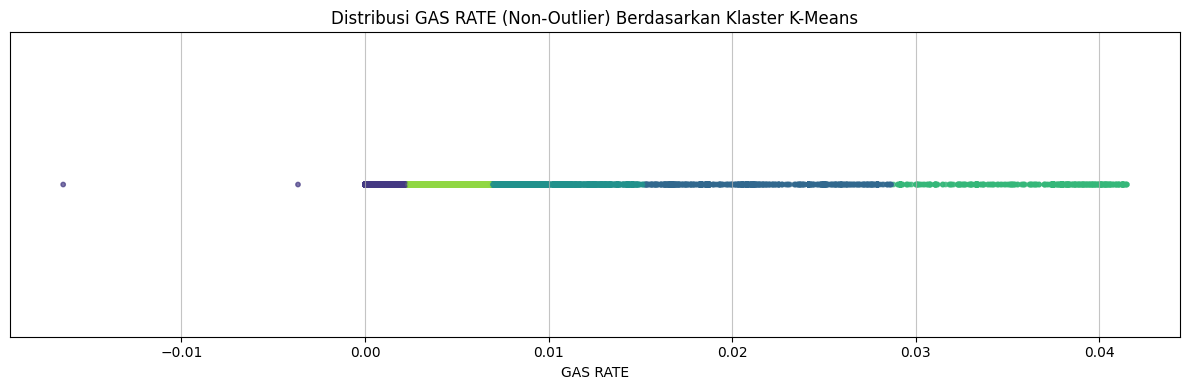


Visualisasi selesai.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported
import numpy as np

# Ensure df_non_outlier and k (from cell c5851d42 and OjdosFsFr7kn) exist
if ('df_non_outlier' not in locals() and 'df_non_outlier' not in globals()):
    print("DataFrame 'df_non_outlier' tidak ditemukan. Pastikan sel filtering non-outlier (seperti c5851d42) sudah dijalankan.")
elif 'GAS RATE' not in df_non_outlier.columns or 'GAS RATE Cluster (KMeans)' not in df_non_outlier.columns:
    print("Kolom 'GAS RATE' atau 'GAS RATE Cluster (KMeans)' tidak ditemukan di DataFrame non-outlier. Pastikan langkah filtering non-outlier dan K-Means sudah berhasil dijalankan.")
elif 'k' not in locals() and 'k' not in globals():
     print("Variabel 'k' (jumlah klaster) tidak ditemukan. Pastikan sel K-Means (seperti OjdosFsFr7kn) sudah dijalankan.")
else:
    print("Membuat scatter plot GAS RATE (Non-Outlier) berdasarkan Klaster K-Means tanpa sumbu Y indeks.")

    # Dynamically generate a color palette based on the number of clusters (k)
    cluster_palette = sns.color_palette("viridis", n_colors=k)


    plt.figure(figsize=(12, 4)) # Adjust figure size for a single line of points

    # Use a simple scatter plot, plotting against a constant Y value
    # Use a small marker size and slight transparency to handle overlap
    # Use the dynamically generated palette. Use list of colors for 'c' argument in scatter.
    # Need to map cluster labels to indices in the palette
    cluster_colors = [cluster_palette[label] for label in df_non_outlier['GAS RATE Cluster (KMeans)']]

    plt.scatter(df_non_outlier['GAS RATE'], np.zeros_like(df_non_outlier['GAS RATE']),
                c=cluster_colors, cmap=None, s=10, alpha=0.7) # Use list of colors with cmap=None


    plt.title('Distribusi GAS RATE (Non-Outlier) Berdasarkan Klaster K-Means')
    plt.xlabel('GAS RATE')
    plt.ylabel('') # Remove Y-axis label
    plt.yticks([]) # Remove Y-axis ticks
    plt.grid(axis='x', alpha=0.75) # Add a grid on the x-axis
    plt.tight_layout() # Adjust layout
    plt.show()

    print("\nVisualisasi selesai.")

In [ ]:
# --- Verification Cell: Display K-Means Cluster Boundaries (Formatted String) ---

# Removed pandas import as DataFrame is no longer expected here
# from IPython.display import display # Keep if using display, but print is sufficient for string

# Check if kmeans_ranges_output exists from the previous cell
if 'kmeans_ranges_output' in locals() or 'kmeans_ranges_output' in globals():
    # Display the formatted string generated in the previous cell
    print(globals().get('kmeans_ranges_output', "Formatted K-Means ranges output not available."))
else:
    print("Variable 'kmeans_ranges_output' not found. Please ensure the K-Means Categorization cell (Fv4cSLsW22aR) was run successfully and generated the output string.")

# Removed debugging prints
# print("DEBUG: kmeans_ranges_df found and is a DataFrame.")
# print(f"DEBUG: Shape of kmeans_ranges_df: {kmeans_ranges_df.shape}")
# if not kmeans_ranges_df.empty:
#      print("DEBUG: kmeans_ranges_df is NOT empty. Displaying head:")
#      display(kmeans_ranges_df.head()) # Display head for debugging
# else:
#      print("DEBUG: kmeans_ranges_df IS empty.")
# print("DEBUG: Attempting to display the full DataFrame.")
# print("Rentang Nilai Berdasarkan Batas Klaster (dalam format tabel):")
# display(kmeans_ranges_df)

Rentang Nilai Berdasarkan Batas Klaster:

--- GAS RATE ---
  very low: < 0.0023
  low: 0.0023 <= value < 0.0069
  moderate: 0.0069 <= value < 0.0152
  high: 0.0152 <= value < 0.0287
  very high: >= 0.0287

--- OIL RATE ---
  very low: < 0.0864
  low: 0.0864 <= value < 0.2904
  moderate: 0.2904 <= value < 0.5186
  high: 0.5186 <= value < 0.7743
  very high: >= 0.7743

--- CONDENSATE RATE ---
  Kategorisasi dilewati karena data tidak mencukupi atau k tidak sesuai.
  Rentang data non-outlier: >= 0.0000 dan <= 0.0000


Mengategorikan data 'GAS RATE' non-outlier menjadi tiga bagian berdasarkan rentang min-max data normal dan memvisualisasikannya.

Menggunakan metode pembagian rentang yang sama (equal interval) pada data non-outlier.

Nilai Min GAS RATE (Non-Outlier): -0.0164
Nilai Max GAS RATE (Non-Outlier): 0.0415
Batas Kategori 1 (Low-Moderate): 0.0029
Batas Kategori 2 (Moderate-High): 0.0222

Kategorisasi 'GAS RATE Non-Outlier Category (Interval)' selesai.

Jumlah data per kategori 'GAS RATE Non-Outlier Category (Interval)':


,count
GAS RATE Non-Outlier Category (Interval),
Moderate,5954
Low,4203
Outlier,1664
High,954
Unknown,1



Membuat histogram distribusi GAS RATE (Non-Outlier) dengan garis pembatas kategori interval...


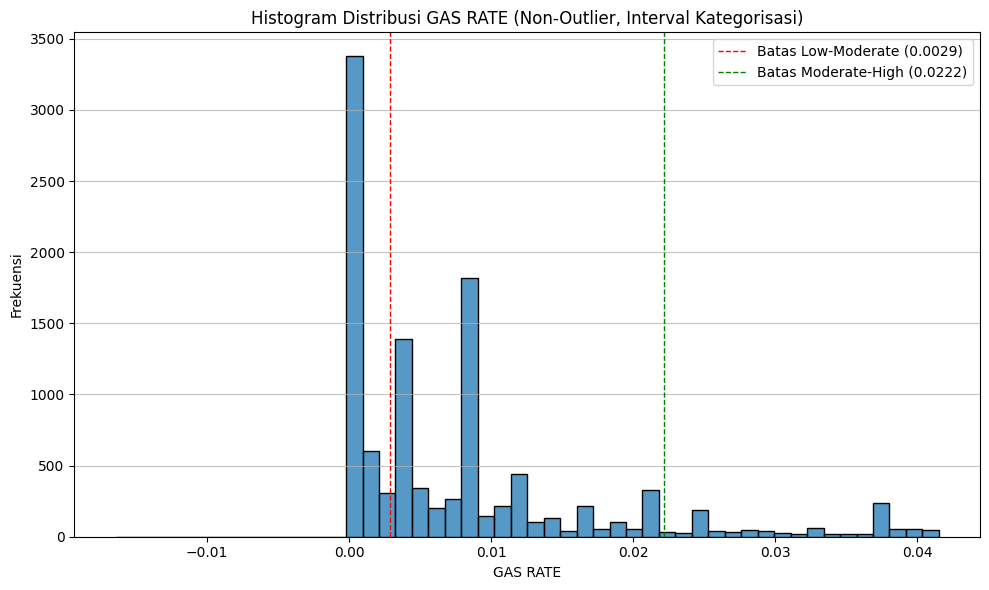


DataFrame dengan kolom kategori non-outlier baru (interval):


KeyError: "['GAS RATE Refined Category', 'GAS RATE Non-Outlier Category', 'GAS RATE Non-Outlier Category (Quantile)'] not in index"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Ensure df is loaded and 'GAS RATE' column is calculated
if 'df' not in locals() and 'df' not in globals():
     print("DataFrame 'df' not found. Please run the cell that loads the data first.")
elif 'GAS RATE' not in df.columns:
     print("Column 'GAS RATE' not found in the DataFrame. Please ensure it is calculated.")
else:
    print("Mengategorikan data 'GAS RATE' non-outlier menjadi tiga bagian berdasarkan rentang min-max data normal dan memvisualisasikannya.")

    # Define a threshold for outlier detection (using IQR method as an example)
    Q1_outlier = df['GAS RATE'].quantile(0.25)
    Q3_outlier = df['GAS RATE'].quantile(0.75)
    IQR_outlier = Q3_outlier - Q1_outlier

    # Define bounds for outliers
    lower_bound_outlier = Q1_outlier - 1.5 * IQR_outlier
    upper_bound_outlier = Q3_outlier + 1.5 * IQR_outlier

    # Filter out outliers and NaN values from 'GAS RATE'
    df_non_outlier = df.loc[(df['GAS RATE'] >= lower_bound_outlier) & (df['GAS RATE'] <= upper_bound_outlier)].copy()
    df_non_outlier = df_non_outlier.dropna(subset=['GAS RATE'])

    if df_non_outlier.empty:
        print("Tidak ada data non-outlier yang valid di kolom 'GAS RATE'. Kategorisasi dan visualisasi tidak dapat dilakukan.")
    else:
        # --- Categorization using Equal Intervals on Non-Outlier Data ---
        print("\nMenggunakan metode pembagian rentang yang sama (equal interval) pada data non-outlier.")

        # Calculate min and max of the non-outlier data
        min_gas_rate = df_non_outlier['GAS RATE'].min()
        max_gas_rate = df_non_outlier['GAS RATE'].max()

        # Divide the range into three equal parts
        range_size = (max_gas_rate - min_gas_rate) / 3
        boundary_1 = min_gas_rate + range_size
        boundary_2 = min_gas_rate + 2 * range_size

        print(f"\nNilai Min GAS RATE (Non-Outlier): {min_gas_rate:.4f}")
        print(f"Nilai Max GAS RATE (Non-Outlier): {max_gas_rate:.4f}")
        print(f"Batas Kategori 1 (Low-Moderate): {boundary_1:.4f}")
        print(f"Batas Kategori 2 (Moderate-High): {boundary_2:.4f}")

        # Create a new column for the refined categories based on the three parts
        def categorize_gas_rate_interval(rate):
            if pd.isna(rate):
                return 'Unknown'
            # Check if the rate falls within the non-outlier range defined by IQR
            if rate < lower_bound_outlier or rate > upper_bound_outlier:
                 return 'Outlier' # Data outside the IQR range

            # Categorize based on equal interval boundaries
            if rate <= boundary_1:
                return 'Low'
            elif rate <= boundary_2:
                return 'Moderate'
            else:
                return 'High'

        # Apply the categorization function to the non-outlier DataFrame
        df_non_outlier['GAS RATE Non-Outlier Category (Interval)'] = df_non_outlier['GAS RATE'].apply(categorize_gas_rate_interval)

        # Add this new column to the original DataFrame as well, marking outliers/unknown
        # Initialize with NaN or a placeholder
        df['GAS RATE Non-Outlier Category (Interval)'] = pd.NA

        # Assign category labels back to the original DataFrame based on index
        df.loc[df_non_outlier.index, 'GAS RATE Non-Outlier Category (Interval)'] = df_non_outlier['GAS RATE Non-Outlier Category (Interval)']

        # For rows that are outliers or NaN in original df but not in df_non_outlier, assign 'Outlier' or 'Unknown'
        # Re-apply the outlier/unknown logic for robustness on the original dataframe
        df.loc[df['GAS RATE'].isna(), 'GAS RATE Non-Outlier Category (Interval)'] = 'Unknown'
        # Identify rows in original df that were outliers based on the initial IQR calculation
        outlier_indices_in_original_df = df.loc[
            (df['GAS RATE'] < lower_bound_outlier) | (df['GAS RATE'] > upper_bound_outlier)
        ].index
        df.loc[outlier_indices_in_original_df, 'GAS RATE Non-Outlier Category (Interval)'] = 'Outlier'


        print("\nKategorisasi 'GAS RATE Non-Outlier Category (Interval)' selesai.")

        # Display value counts for the new refined category
        print("\nJumlah data per kategori 'GAS RATE Non-Outlier Category (Interval)':")
        display(df['GAS RATE Non-Outlier Category (Interval)'].value_counts(dropna=False)) # Include NaN counts


        # --- Create Histogram with Interval Boundary Lines on Non-Outlier Data ---

        print("\nMembuat histogram distribusi GAS RATE (Non-Outlier) dengan garis pembatas kategori interval...")

        # Filter out rows where the new category is 'Outlier' or 'Unknown' for plotting
        # Use the original df for plotting but filter by the new interval category
        df_plot_interval = df.loc[
            (df['GAS RATE Non-Outlier Category (Interval)'] != 'Outlier') &
            (df['GAS RATE Non-Outlier Category (Interval)'] != 'Unknown')
        ].copy()

        if not df_plot_interval.empty:
            plt.figure(figsize=(10, 6))
            sns.histplot(data=df_plot_interval, x='GAS RATE', kde=False, bins=50) # Adjust bins as needed
            plt.title('Histogram Distribusi GAS RATE (Non-Outlier, Interval Kategorisasi)')
            plt.xlabel('GAS RATE')
            plt.ylabel('Frekuensi')

            # Add vertical lines for interval category boundaries
            plt.axvline(boundary_1, color='red', linestyle='dashed', linewidth=1, label=f'Batas Low-Moderate ({boundary_1:.4f})')
            plt.axvline(boundary_2, color='green', linestyle='dashed', linewidth=1, label=f'Batas Moderate-High ({boundary_2:.4f})')

            plt.legend() # Show the legend for the boundary lines
            plt.grid(axis='y', alpha=0.75) # Add a grid
            plt.tight_layout()
            plt.show()
        else:
             print("Tidak ada data non-outlier yang valid untuk diplot setelah kategorisasi interval.")

    # Optional: Display head of df with the new column
    print("\nDataFrame dengan kolom kategori non-outlier baru (interval):")
    display(df[['GAS RATE', 'GAS RATE Refined Category', 'GAS RATE Non-Outlier Category', 'GAS RATE Non-Outlier Category (Quantile)', 'GAS RATE Non-Outlier Category (Interval)']].head())

In [ ]:
# Ensure df exists and has the 'GAS RATE Refined Category' column
if 'df' in locals() or 'df' in globals():
    if 'GAS RATE Refined Category' in df.columns:
        # Count the occurrences of each category in 'GAS RATE Refined Category'
        category_counts = df['GAS RATE Refined Category'].value_counts()

        print("Jumlah data per kategori 'GAS RATE Refined Category':")
        display(category_counts)

        # You can also calculate total non-outliers by summing 'High', 'Moderate', and 'Low'
        non_outlier_count = category_counts.get('High', 0) + category_counts.get('Moderate', 0) + category_counts.get('Low', 0)
        outlier_count = category_counts.get('Outlier', 0)
        unknown_count = category_counts.get('Unknown', 0)


        print(f"\nTotal data Non-Outlier: {non_outlier_count}")
        print(f"Total data Outlier: {outlier_count}")
        print(f"Total data Unknown Category: {unknown_count}")


    else:
        print("Kolom 'GAS RATE Refined Category' tidak ditemukan di DataFrame. Pastikan langkah kategorisasi sudah dijalankan.")
else:
    print("DataFrame 'df' tidak ditemukan. Mohon jalankan sel yang memuat data terlebih dahulu.")

Jumlah data per kategori 'GAS RATE Refined Category':


,count
GAS RATE Refined Category,
Moderate,3848
Low,3742
High,3521
Outlier,1664
Unknown,1



Total data Non-Outlier: 11111
Total data Outlier: 1664
Total data Unknown Category: 1


In [ ]:
import pandas as pd
from IPython.display import display

# Ensure df exists and has the 'GAS RATE' column
if 'df' in locals() or 'df' in globals():
    if 'GAS RATE' in df.columns:
        # Filter rows where 'GAS RATE' is negative
        negative_gas_rate_count = df[df['GAS RATE'] < 0].shape[0]

        print(f"Jumlah angka negatif pada kolom 'GAS RATE': {negative_gas_rate_count}")

    else:
        print("Kolom 'GAS RATE' tidak ditemukan di DataFrame. Pastikan kolom tersebut sudah dihitung.")
else:
    print("DataFrame 'df' tidak ditemukan. Mohon jalankan sel yang memuat data terlebih dahulu.")

Jumlah angka negatif pada kolom 'GAS RATE': 2


In [ ]:
import pandas as pd
from IPython.display import display # Import display for better output in Colab
import os

# Calculate the new columns
# Handle potential division by zero by replacing 0 downtime with a small value or NaN, depending on desired behavior.
# Here, we'll replace 0 with NaN to avoid division by zero and represent undefined rate.
df['GAS RATE'] = df['EVENTDAYLOSSGAS'] / df['EVENTDAYDOWNTIME'].replace(0, pd.NA)
df['OIL RATE'] = df['EVENTDAYLOSSOIL'] / df['EVENTDAYDOWNTIME'].replace(0, pd.NA)
df['CONDENSATE RATE'] = df['EVENTDAYLOSSCONDENSATEFORMATION'] / df['EVENTDAYDOWNTIME'].replace(0, pd.NA)

# Add SIBU/NonSIBU column
# Use .str.contains() with case=False to make the search case-insensitive
# Use fillna('') to handle potential NaN values in 'ROOTCAUSEDESCRIPTION' before applying .str
df['SIBU/NonSIBU'] = df['ROOTCAUSEDESCRIPTION'].fillna('').str.contains('SIBU', case=False).apply(lambda x: 'SIBU' if x else 'NonSIBU')


# --- Code to save the updated DataFrame to an Excel file ---

# Prompt user for the output file path
output_file_path = input("Masukkan path file Excel (.xlsx) untuk menyimpan data yang diperbarui: ")

try:
    # Save the DataFrame to an Excel file
    # index=False prevents writing the DataFrame index as a column in the Excel file
    df.to_excel(output_file_path, index=False)
    print(f"DataFrame berhasil disimpan ke '{output_file_path}'")
except Exception as e:
    print(f"Terjadi error saat menyimpan file: {e}")

# Display the first few rows with the new columns after saving
display(df[['EVENTDAYLOSSGAS', 'EVENTDAYLOSSOIL', 'EVENTDAYLOSSCONDENSATEFORMATION', 'EVENTDAYDOWNTIME', 'GAS RATE', 'OIL RATE', 'CONDENSATE RATE', 'ROOTCAUSEDESCRIPTION', 'SIBU/NonSIBU']].head())

Masukkan path file Excel (.xlsx) untuk menyimpan data yang diperbarui: /content/drive/MyDrive/Proyekan Mas Ivan/SF Jan-Aug 2025.xlsx
DataFrame berhasil disimpan ke '/content/drive/MyDrive/Proyekan Mas Ivan/SF Jan-Aug 2025.xlsx'


,EVENTDAYLOSSGAS,EVENTDAYLOSSOIL,EVENTDAYLOSSCONDENSATEFORMATION,EVENTDAYDOWNTIME,GAS RATE,OIL RATE,CONDENSATE RATE,ROOTCAUSEDESCRIPTION,SIBU/NonSIBU
0,0.180000,0.000000,0.0,24.000000,0.007500,0.000000,0.0,Shut in due to cause HP2 repetitive pumping,NonSIBU
1,0.000000,1.092901,0.0,2.916667,0.000000,0.374709,0.0,Shut in during additional perfo by Sea heaven-07,NonSIBU
2,0.500000,223.000000,0.0,24.000000,0.020833,9.291667,0.0,"06.00, Shut in d/t BL-2S as GP mode",NonSIBU
3,0.083333,0.000000,0.0,24.000000,0.003472,0.000000,0.0,SIBU,SIBU
4,0.200000,250.000000,0.0,24.000000,0.008333,10.416667,0.0,"16.00, SIBU d/t leak on actuator SSV 16101",SIBU
